In [1]:
import tensorflow as tf
import numpy as np
from numpy.random import RandomState
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import platform

In [2]:
print("Environment: TensorFlow %s, Python %s" % (tf.__version__, platform.python_version()))

Environment: TensorFlow 1.15.0, Python 3.7.9


In [3]:
!wget https://raw.githubusercontent.com/ThomasAtlantis/SJTUNNTA/master/MLQP/data.txt

data = np.array(list(map(
	lambda _: list(map(float, _)), 
	[line.strip().split() for line in open("data.txt", "r").readlines()]
)))

--2021-04-07 14:03:06--  https://raw.githubusercontent.com/ThomasAtlantis/SJTUNNTA/master/MLQP/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4460 (4.4K) [text/plain]
Saving to: ‘data.txt.8’

data.txt.8          100%[===================>]   4.36K  --.-KB/s    in 0.001s  

2021-04-07 14:03:08 (4.74 MB/s) - ‘data.txt.8’ saved [4460/4460]



In [4]:
# RANDOMLY = True
RANDOMLY = False

In [5]:
subsets = []
if RANDOMLY == True:
    np.random.shuffle(data)
    division = data.shape[0] // 2
    subset_0, subset_1 = [data[:division], data[division:]]
    subset_2 = np.vstack([subset_0[subset_0[:, 2] == 1], subset_1[subset_1[:, 2] == 0]])
    subset_3 = np.vstack([subset_0[subset_0[:, 2] == 0], subset_1[subset_1[:, 2] == 1]])
    np.random.shuffle(subset_2)
    np.random.shuffle(subset_3)
    subsets = [subset_0, subset_1, subset_2, subset_3]
else:
    DISTANCE_THRESHOLD = 3.5
    subset_0 = np.array(list(filter(lambda d: np.sqrt(d[0]**2 + d[1]**2) < DISTANCE_THRESHOLD, data)))
    subset_1 = np.array(list(filter(lambda d: np.sqrt(d[0]**2 + d[1]**2) >=DISTANCE_THRESHOLD, data)))
    subset_2 = np.vstack([subset_0[subset_0[:, 2] == 1], subset_1[subset_1[:, 2] == 0]])
    subset_3 = np.vstack([subset_0[subset_0[:, 2] == 0], subset_1[subset_1[:, 2] == 1]])

    np.random.shuffle(subset_2)
    np.random.shuffle(subset_3)
    subsets = [subset_0, subset_1, subset_2, subset_3]

In [10]:
# Hyper-parameters
EPOCH, learning_rate = 500, 0.0015
featre_dim, hidden_dim, output_dim = 2, 32, 1

# define and initialize weights and biases
u1 = tf.Variable(tf.random.normal([featre_dim, hidden_dim], seed=1))
v1 = tf.Variable(tf.random.normal([featre_dim, hidden_dim], seed=1))
b1 = tf.Variable(tf.random.normal([hidden_dim], seed=1))

u2 = tf.Variable(tf.random.normal([hidden_dim, output_dim], seed=1))
v2 = tf.Variable(tf.random.normal([hidden_dim, output_dim], seed=1))
b2 = tf.Variable(tf.random.normal([output_dim], seed=1))

# define input placeholder and target placeholder
X = tf.placeholder(tf.float32, shape=(None, featre_dim))
y = tf.placeholder(tf.float32, shape=(None, output_dim))

# define forward propagation process
t = tf.tanh(   tf.matmul(tf.square(X), u1) + tf.matmul(X, v1) + b1)
h = tf.sigmoid(tf.matmul(tf.square(t), u2) + tf.matmul(t, v2) + b2)

# define loss as cross entropy
loss = tf.reduce_mean(binary_crossentropy(y, h))

# use Adam optimizer
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

train_acc, train_bds = [], []
grid1 = np.linspace(-7, 7, 100)
grid2 = np.linspace(-7, 7, 100)
xx, yy = np.meshgrid(grid1, grid2)
Grid = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T


# training ...
for k, subset in enumerate(subsets):
    train_X, train_y = subset[:,:2].reshape(-1, 2), subset[:, 2].reshape(-1, 1)
    print(train_X.shape, train_y.shape)

    saver = tf.train.Saver()
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        print("training subset %d ..." % k)
        epoch = 4000 if k ==1 else EPOCH
        for i in range(epoch):
            
            # online learning 
            for _X, _y in zip(train_X, train_y):
                sess.run(train_step, feed_dict={
                    X: _X.reshape(1, 2), 
                    y: _y.reshape(1, 1)
                })
            
            # log current loss and accuracy
            if i % 100 == 0:
                los, y_hat = sess.run([loss, h], feed_dict={X: train_X, y: train_y})
                acc = np.where(np.abs(y_hat - train_y)[:, 0] < 0.5)[0].size / train_y.size
                print("After {:>5d} training_step(s), los: {:.4f}, acc: {:.4f}".format(i, los, acc))
                # log_train_acc.append(acc)
                # log_train_los.append(los)
        
        y_hat = sess.run(h, feed_dict={X: train_X})
        train_acc.append(np.where(np.abs(y_hat - train_y)[:, 0] < 0.5)[0].size / train_y.size)
        y_hat = sess.run(h, feed_dict={X: Grid})
        train_bds.append(np.argmax(np.hstack([1-y_hat, y_hat]), axis=-1).reshape(xx.shape))
                
        # save the model
        saver.save(sess, "MLQPModel/model-%d.ckpt" % k)

(96, 2) (96, 1)
training subset 0 ...
After     0 training_step(s), los: 6.5651, acc: 0.5000
After   100 training_step(s), los: 0.2596, acc: 0.8750
After   200 training_step(s), los: 0.0304, acc: 1.0000
After   300 training_step(s), los: 0.0014, acc: 1.0000
After   400 training_step(s), los: 0.0001, acc: 1.0000
(98, 2) (98, 1)
training subset 1 ...
After     0 training_step(s), los: 5.9373, acc: 0.5000
After   100 training_step(s), los: 0.5602, acc: 0.6633
After   200 training_step(s), los: 0.4931, acc: 0.7143
After   300 training_step(s), los: 0.4448, acc: 0.7653
After   400 training_step(s), los: 0.4108, acc: 0.7959
After   500 training_step(s), los: 0.3895, acc: 0.8163
After   600 training_step(s), los: 0.3712, acc: 0.8265
After   700 training_step(s), los: 0.3598, acc: 0.8265
After   800 training_step(s), los: 0.3496, acc: 0.8265
After   900 training_step(s), los: 0.3416, acc: 0.8265
After  1000 training_step(s), los: 0.3338, acc: 0.8367
After  1100 training_step(s), los: 0.3269, a

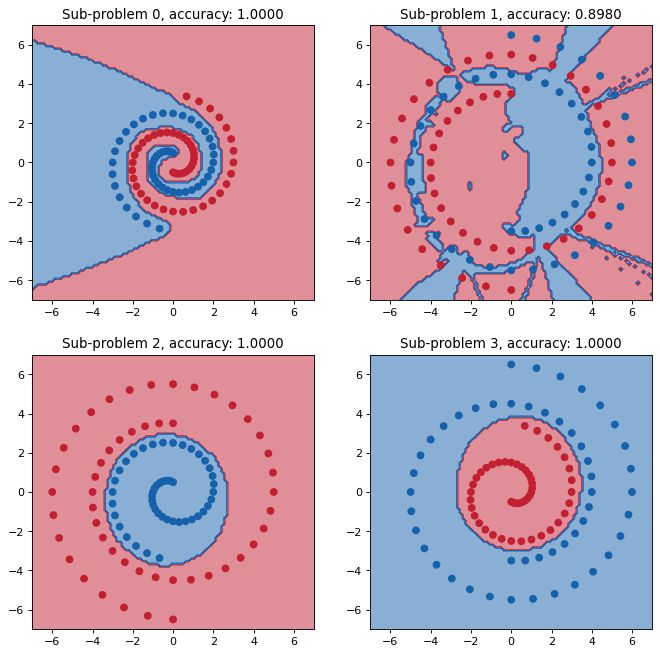

In [11]:
plt.figure(figsize=(10, 10), dpi=80)
color_map = colors.ListedColormap(["#c21f30", "#1661ab"])
for i, (acc, bds) in enumerate(zip(train_acc, train_bds)):
    plt.subplot(2, 2, i + 1)
    plt.title("Sub-problem %d, accuracy: %.4f" % (i, acc))
    plt.contourf(xx, yy, bds, cmap=color_map, alpha=0.5)
    plt.scatter(subsets[i][:, 0], subsets[i][:, 1], c=subsets[i][:, 2], cmap=color_map)
plt.show()

INFO:tensorflow:Restoring parameters from MLQPModel/model-0.ckpt
INFO:tensorflow:Restoring parameters from MLQPModel/model-1.ckpt
INFO:tensorflow:Restoring parameters from MLQPModel/model-2.ckpt
INFO:tensorflow:Restoring parameters from MLQPModel/model-3.ckpt
INFO:tensorflow:Restoring parameters from MLQPModel/model-0.ckpt
INFO:tensorflow:Restoring parameters from MLQPModel/model-1.ckpt
INFO:tensorflow:Restoring parameters from MLQPModel/model-2.ckpt
INFO:tensorflow:Restoring parameters from MLQPModel/model-3.ckpt
(194, 1)


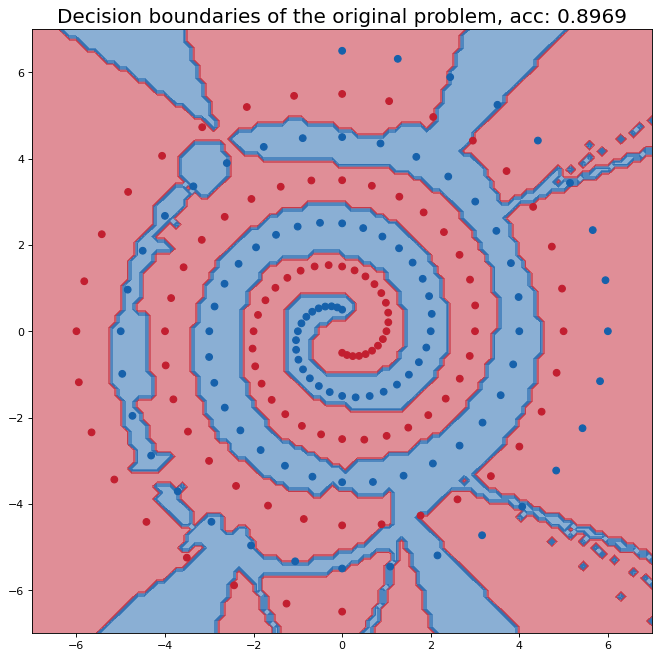

In [12]:
def inference(inputs):
    results = []
    for i, subset in enumerate(subsets):
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, "MLQPModel/model-%d.ckpt" % i)
            results.append(np.array(sess.run(h, feed_dict={X: inputs})))
    results = np.squeeze(np.array(results))
    y_hat = np.max(np.vstack([
        np.min(results[[0, 2], :], axis=0), 
        np.min(results[[1, 3], :], axis=0)
    ]), axis=0).reshape(-1, 1)
    return y_hat
y_hat = inference(Grid)
zz = np.argmax(np.hstack([1-y_hat, y_hat]), axis=-1).reshape(xx.shape)
y_hat = inference(data[:, :2])
print(y_hat.shape)
accy = np.where(np.abs(y_hat - data[:, 2])[:, 0] < 0.5)[0].size / train_y.size

plt.figure(figsize=(10, 10), dpi=80)
plt.title("Decision boundaries of the original problem, acc: %.4f" % accy, fontsize=18)
plt.contourf(xx, yy, zz, cmap=color_map, alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap=color_map)
plt.show()